## General Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import plotly.express as px
import statsmodels.api as sm

from custom_functions import store_json

## Data Collection

In [ ]:
# Make the Data RAM available
df_instances = pd.read_csv("./data/Train_call.txt", sep='\t')
df_solution = pd.read_csv("./data/Train_clinical.txt", sep='\t')

### Class Balance?

In [ ]:
from collections import Counter
Counter(df_solution["Subgroup"])

Counter({'HER2+': 32, 'HR+': 36, 'Triple Neg': 32})

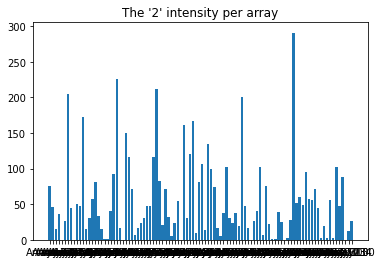

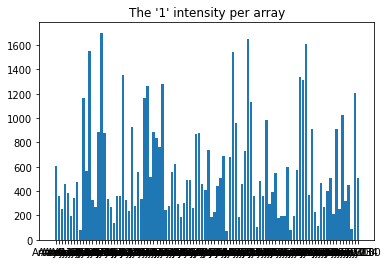

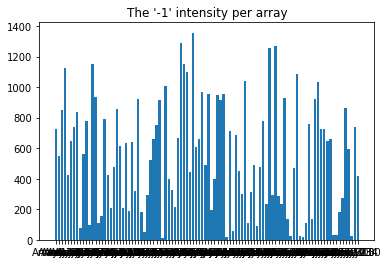

In [ ]:
selection = dict()

for checkup in [2, 1, 0, -1]:
    new_key = str(checkup)
    col_name = "Array."

    selection[new_key] = df_instances[df_instances[[x for x in df_instances.columns if col_name in x]] == checkup].count()
    selection[new_key] = selection[new_key].to_dict()

    removables = [
        "Chromosome",
        "Start",
        "End",
        "Nclone",
    ]

    [selection[new_key].pop(name, None) for name in removables]

for intensity in selection:
    if intensity == "0":
        continue
    fig, ax = plt.subplots()
    ax.set_title(f"The '{intensity}' intensity per array")
    # print(f"The {intensity} intensity per array")
    plt.bar(*zip(*selection[intensity].items()))
    plt.show()

## Prep and Split Data

In [ ]:
df_instances = df_instances.T

NameError: name 'df_instances' is not defined

In [ ]:
# Assign the target value to the 'training data' so we have a superset

# Run this command on any given preconfigured dataset. If you set the target values as ints, the column is started as
# an int-based dtype. Otherwise, use None so we can assign strings
df_instances["Subgroup"] = None if type(df_solution.Subgroup.values[-1]) != int else 0

for arr_name in df_solution["Sample"]:
    df_instances.at[arr_name, "Subgroup"] =\
     df_solution[df_solution["Sample"] == arr_name]["Subgroup"].values[0]

In [ ]:
# for now, lets remove chromosome numbers etc. 
# (might be useful in later stages when trying to optimize the model but for now we just need to check the feature space)

dffinal = df_instances.drop([
    "Chromosome",
    "Start",
    "End",
    "Nclone"
])

In [ ]:
dffinal

,0,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,Subgroup
Array.129,0,0,0,0,0,0,0,0,0,0,...,2,2,2,0,1,1,1,1,1,HER2+
Array.34,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
Array.67,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
Array.24,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,Triple Neg
Array.22,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,Triple Neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array.10,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,HER2+
Array.123,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
Array.100,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
Array.134,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,HR+


## PCA

In [ ]:
from sklearn.decomposition import PCA

n_components = 6

pca_app = PCA(n_components=n_components)
pca_app.fit(dffinal.drop(["Subgroup"], axis=1))
M = pca_app.transform(dffinal.drop(["Subgroup"], axis=1))

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca_app.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    M,
    labels=labels,
    dimensions=range(n_components),
    color=dffinal["Subgroup"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
total_var = pca_app.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(M, x=0, y=1, z=2, color=dffinal['Subgroup'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
# %matplotlib widget

# # Set general styling
# sns.set_style("white")

# # create figure
# my_dpi=96
# plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
# # Keep the target column appart + make it numeric for coloring
# dffinal['Subgroup'] = pd.Categorical(dffinal['Subgroup'])
# my_color = dffinal['Subgroup'].cat.codes
# df_vals = dffinal.drop(["Subgroup"], axis=1)

# # THIS IS NOT ALLOWED BUT I NEEDED TO SEE THE 3D SPACE IN A NORMAL CONFIG :3
# M[0][0] = (M[0][0]/1000 - 65)
 
# # Store results of PCA in a data frame
# pca_result = pd.DataFrame(M, columns=[f'PCA{i}' for i in range(3)], index=df_vals.index)

# # Plot initialisation
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pca_result['PCA0'], pca_result['PCA1'], pca_result['PCA2'], c=my_color, cmap="Set2_r", s=60)
 
# # make simple, bare axis lines through space:
# xAxisLine = ((min(pca_result['PCA0']), max(pca_result['PCA0'])), (0, 0), (0,0))
# ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
# yAxisLine = ((pca_result['PCA0'].mean(), pca_result['PCA0'].mean()), (min(pca_result['PCA1']), max(pca_result['PCA1'])), (0,0))
# ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
# zAxisLine = ((pca_result['PCA0'].mean(), pca_result['PCA0'].mean()), (0,0), (min(pca_result['PCA2']), max(pca_result['PCA2'])))
# ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# # label the axes
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# ax.set_title("PCA Space of Array features")
# plt.show()

## Correlations

### Potential Subquestion: Do regular numerical values as the target classification, instead of its categorical origin, create artefacts in feature selection?

In [ ]:
# Get the feature correlation so we can exclude (hopefully) a lot of features (since we are working with 2835 of them...)
corr_ = df_instances.corr()

In [ ]:
# So we don't have to rerun it every time
# try:
#     corr_.to_csv("./data/correlations.csv")
# except:
#     print("Failed to store the correlations data permanently ;( ")
#     pass

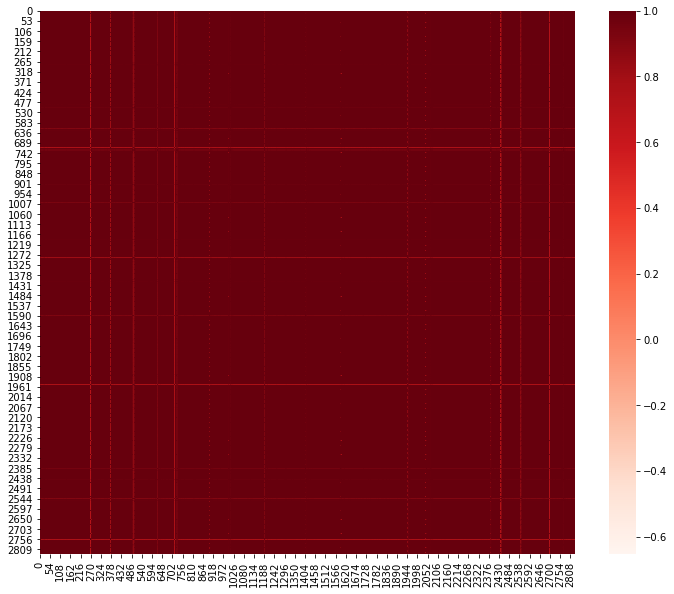

In [ ]:
# Lets see if we can plot it, because a plot can tell more than a thousands words (right?)
try:
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_, # annot=True, # Annotations will take an incredibly long time... better to leave them off
    cmap=plt.cm.Reds)
    plt.show()
except Exception as exc:
    print(f"While working without supervision...\nEncountered {exc}")

In [ ]:
corr_

,0,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,Subgroup
0,1.000000,0.952802,0.751004,0.888783,0.792765,0.846584,0.818860,0.754807,0.853392,0.759991,...,0.749708,0.749469,0.750215,0.749562,0.750283,0.749486,0.750364,0.749541,0.750505,-0.490009
1,0.952802,1.000000,0.916020,0.985979,0.940396,0.968216,0.954472,0.918322,0.971367,0.921436,...,0.915232,0.915086,0.915540,0.915143,0.915582,0.915097,0.915631,0.915130,0.915717,-0.598263
2,0.751004,0.916020,1.000000,0.970113,0.997839,0.987235,0.993974,0.999983,0.985094,0.999906,...,0.999998,0.999997,0.999999,0.999998,0.999999,0.999997,1.000000,0.999998,1.000000,-0.653786
3,0.888783,0.985979,0.970113,1.000000,0.983960,0.996377,0.990866,0.971499,0.997393,0.973350,...,0.969635,0.969547,0.969822,0.969581,0.969847,0.969553,0.969877,0.969573,0.969929,-0.633867
4,0.792765,0.940396,0.997839,0.983960,1.000000,0.995566,0.999028,0.998202,0.994267,0.998647,...,0.997709,0.997684,0.997760,0.997694,0.997767,0.997686,0.997775,0.997691,0.997789,-0.652272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,0.749486,0.915097,0.999997,0.969553,0.997686,0.986867,0.993719,0.999967,0.984696,0.999872,...,1.000000,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,-0.653783
2831,0.750364,0.915631,1.000000,0.969877,0.997775,0.987080,0.993867,0.999977,0.984927,0.999892,...,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,-0.653783
2832,0.749541,0.915130,0.999998,0.969573,0.997691,0.986880,0.993729,0.999968,0.984711,0.999873,...,1.000000,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,-0.653783
2833,0.750505,0.915717,1.000000,0.969929,0.997789,0.987114,0.993891,0.999979,0.984964,0.999895,...,0.999999,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,-0.653783


In [ ]:
#Correlation with output variable
cor_target = abs(corr_.Subgroup)

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.653786] # 0.653786 is selected by looking at the data manually.

relevant_features

1194        0.653788
1198        0.653786
1200        0.653787
1878        0.653794
2045        0.653795
2046        0.653795
2047        0.653792
2052        0.653787
2055        0.653787
2060        0.653787
2061        0.653787
2442        0.653794
2549        0.653786
2765        0.653803
2771        0.653788
Subgroup    1.000000
Name: Subgroup, dtype: float64

Looks like we have our victims for the Neural Net:

In [ ]:
selected_features = list(relevant_features.index)

store_json(selected_features, "./data/min_feat_selection.json")

Stored file at ./data/min_feat_selection.json


In [ ]:
dffinal.to_csv("./data/superset.csv")

### Potential Subquestion: Does feature selection improve model performance / build-time?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c915e4f9-60c2-40b5-a522-8a90cb3fd50a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>